# Segmentation


This workbook aims to propose  a nice customers segmentation that will help the company to spend marketing money more wisely.
For running this code, it's necessary to have available 'data_model.csv' file created by EDA.ipynb file contained in the same folder.

This segmentation will be based on customer's behaviors. Due to this, after the EDA step, 4 features were chosen:
<br>
<il>
    <li>Total_Purchases </li>
    <li>AOV </li>
    <li>Recency </li>
    <li>channel_factor ( %CatalogPurchases - %StorePurchases )</li>
</il>


With those features, it is expected to nicely segment customers by value to the company.

The method I'll use consists in using K-Means for <b>clustering separatelly each one of the variables, then combining all of them in a final segmentation </b> which aims to identify very active (Recency & Total_Purchases), high AOV customers who tends to buy from Catalogs or Web (channels factor).

K-Means is an unsupervised learning algorithm that finds similar groups within our dataset. In the math world, "similarity" is measured by distance (Euclidean) between two points. This algorithm finds K clusters (represented by centers points) which the total distance between centers and datapoints is the smallest.





In [1042]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


Lets define a function that will sort our clusters in a way that Cluster #1 is the smallest value (i.e. smallest AOV) and the number of the cluster grows as the target feature increases.

In [1043]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [1044]:
df=pd.read_csv('data_modelo.csv')

In [1045]:
df.head()

,Unnamed: 0,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Years_as_Customer,Family_Size,Total_income_familymember,Total_Conv,RecentCmp,Total_spent,Total_spent_percent_income,Total_Purchases,AOV,Total_Purchases_year,%Wine,%Fruit,%Meat,%Fish,%Sweet,%Gold,%WebPurchases,%CatalogPurchases,%StorePurchases,%DealPurchases,products_factor,Deal_purchases,channels_factor,Basic,Graduation,Master,PhD,Married,Single,Together,Widow
0,0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,63,8,1,58138.0,0,0,1529,0.013150,22,66.478261,2.750000,0.005461,0.000757,0.004696,0.001479,0.000757,0.000757,0.347826,0.434783,0.173913,0.130435,0.286745,0,0.887593,0,1,0,0,0,1,0,0
1,1,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,66,6,3,15448.0,0,0,21,0.000227,4,4.200000,0.666667,0.000356,0.000032,0.000194,0.000065,0.000032,0.000194,0.200000,0.200000,0.400000,0.400000,0.015534,0,0.482927,0,1,0,0,0,1,0,0
2,2,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,55,7,1,71613.0,0,0,734,0.005125,20,34.952381,2.857143,0.002974,0.000342,0.000887,0.000775,0.000147,0.000293,0.380952,0.095238,0.476190,0.047619,0.109003,0,0.324042,0,1,0,0,0,0,1,0
3,3,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,36,6,2,13323.0,0,0,48,0.000901,6,6.857143,1.000000,0.000413,0.000150,0.000751,0.000375,0.000113,0.000188,0.285714,0.000000,0.571429,0.285714,0.032845,0,0.156794,0,1,0,0,0,0,1,0
4,4,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,39,6,2,29146.5,0,0,407,0.003491,14,27.133333,2.333333,0.002968,0.000738,0.002024,0.000789,0.000463,0.000257,0.333333,0.200000,0.400000,0.333333,0.140933,0,0.482927,0,0,0,1,1,0,0,0


In [1046]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)

# Total_Purchases Score

In [1047]:
df_clusterizacao=df[['Total_Purchases']]

The K-means algorithm depends on the number of clusters (k) that we choose. In order to define an apropriate number of clusters, it's common to use the "Elbow Method" which consists of iteratively running k-means with different k values. For each run, its calculated the total error (sum of distance of each data point to its cluster center).
The optimum number of clusters is the minimum possible in wich the decrement of error is too small.

For exemple: As shown in the chart below, in the case of Total_Purchases the difference in total error between 3 or 4 clusters are really small, so we choose 3 clusters.

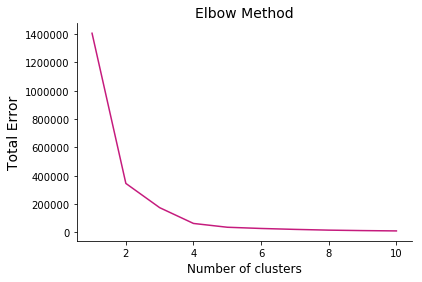

In [1048]:
total_error = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(df_clusterizacao)
    total_error.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('Total Error', size=14)
plt.show()

# Creating and training the Model

In [1049]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)

y_means = kmeans.fit_predict(df_clusterizacao)

In [1050]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = df_clusterizacao.columns)
centroids

,Total_Purchases
0,13.827957
1,21.535842
2,5.296117


Our clusters are centered in the points above. Lets add this information to our dataset.

In [1051]:
df['Cluster_Purchases']= kmeans.predict(df_clusterizacao)

In [1052]:
df = order_cluster('Cluster_Purchases', 'Total_Purchases',df,True)

In [1053]:
df.groupby('Cluster_Purchases')['Total_Purchases'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster_Purchases,,,,,,,,
0,824.0,5.296117,1.642298,1.0,4.0,5.0,6.0,9.0
1,558.0,13.827957,2.228219,10.0,12.0,14.0,16.0,17.0
2,558.0,21.535842,2.869008,18.0,19.0,21.0,23.0,32.0


Notice that now cluster 2 contains the customers who have a minimum of 18 total purchases, and in average 21.5 purchases.

# Recency Score

In [1054]:
df_clusterizacao=df[['Recency']]

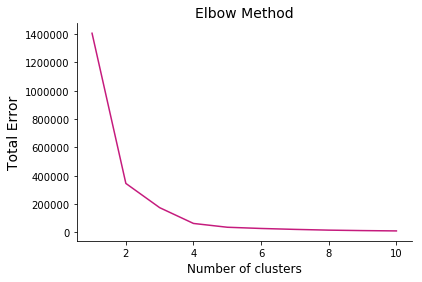

In [1055]:
total_error = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(df_clusterizacao)
    total_error.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('Total Error', size=14)
plt.show()

In [1056]:

kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)

y_means = kmeans.fit_predict(df_clusterizacao)

In [1057]:

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = df_clusterizacao.columns)
centroids

,Recency
0,82.903175
1,16.029806
2,50.029734


In [1058]:
df['Cluster_Recency']= kmeans.predict(df_clusterizacao)

In [1059]:
df = order_cluster('Cluster_Recency', 'Recency',df,False)

In [1060]:

df.groupby('Cluster_Recency')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster_Recency,,,,,,,,
0,630.0,82.903175,9.303665,67.0,75.0,83.0,91.0,99.0
1,639.0,50.029734,9.264016,34.0,42.0,50.0,57.0,66.0
2,671.0,16.029806,10.036010,0.0,8.0,16.0,25.0,33.0


Our Recency_Cluster number 0 contains customers who made a purchase 67 days ago minimum, while cluster number 2 contains customers who bought something 33 days ago maximum.

# AOV Score

In [1061]:
df_clusterizacao=df[['AOV']]

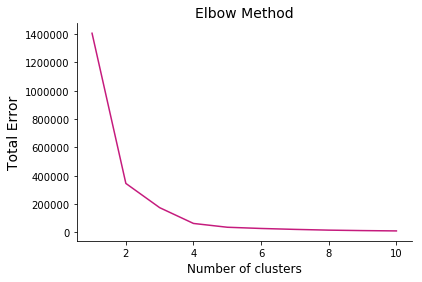

In [1062]:
total_error = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(df_clusterizacao)
    total_error.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('Total Error', size=14)
plt.show()

In [1063]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
y_means = kmeans.fit_predict(df_clusterizacao)

In [1064]:

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = df_clusterizacao.columns)
centroids

,AOV
0,31.191991
1,74.281615
2,8.826331


In [1065]:
df['Cluster_AOV']= kmeans.predict(df_clusterizacao)
df = order_cluster('Cluster_AOV', 'AOV',df,True)

In [1066]:
df.groupby('Cluster_AOV')['AOV'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster_AOV,,,,,,,,
0,843.0,8.866095,4.631361,1.500000,5.225000,7.800000,11.375000,20.000000
1,660.0,31.242864,7.602205,20.090909,25.000000,30.416667,36.489648,52.666667
2,437.0,74.281615,16.498842,52.888889,64.210526,65.300000,88.615385,119.333333


Our AOV Cluster is the most unbalanced so far, since cluster 2 have ~7x less customers than cluster 0. That also reflects the skewness of our data.

# Channels Score

In [1067]:
df_clusterizacao=df[['channels_factor']]

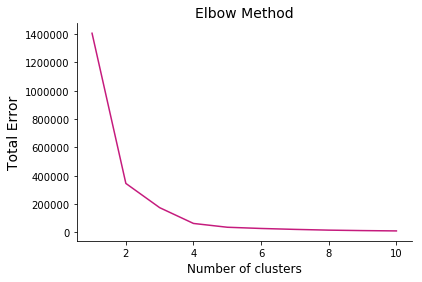

In [1068]:
total_error = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(df_clusterizacao)
    total_error.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('Total Error', size=14)
plt.show()

In [1069]:

kmeans = KMeans(n_clusters=3, init='k-means++',random_state=0)
y_means = kmeans.fit_predict(df_clusterizacao)

In [1070]:

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = df_clusterizacao.columns)
centroids

,channels_factor
0,0.219849
1,0.452897
2,0.712644


In [1071]:
df['Cluster_Channels']= kmeans.predict(df_clusterizacao)
df = order_cluster('Cluster_Channels', 'channels_factor',df,True)
df.groupby('Cluster_Channels')['channels_factor'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster_Channels,,,,,,,,
0,794.0,0.219849,0.076280,0.000000,0.156794,0.219512,0.282230,0.335045
1,882.0,0.452897,0.067591,0.339246,0.395122,0.449477,0.512195,0.582185
2,264.0,0.712644,0.095420,0.585366,0.624765,0.698531,0.783972,1.000000


As we can see, customerns on our Cluster buy a minimum of 62 p.p. more in Catalogs than Stores.

# Combining all scores for our final Segmentation

In [1072]:
df['Cluster_final']=df['Cluster_Purchases']+df['Cluster_Recency']+df['Cluster_AOV']+df['Cluster_Channels']

In [1073]:
df.groupby('Cluster_final')['Response'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster_final,,,,,,,,
0,180.0,0.022222,0.147817,0.0,0.0,0.0,0.0,1.0
1,287.0,0.031359,0.174590,0.0,0.0,0.0,0.0,1.0
2,302.0,0.076159,0.265693,0.0,0.0,0.0,0.0,1.0
3,216.0,0.194444,0.396692,0.0,0.0,0.0,0.0,1.0
4,277.0,0.115523,0.320231,0.0,0.0,0.0,0.0,1.0
5,306.0,0.150327,0.357977,0.0,0.0,0.0,0.0,1.0
6,212.0,0.268868,0.444421,0.0,0.0,0.0,1.0,1.0
7,130.0,0.446154,0.499015,0.0,0.0,0.0,1.0,1.0
8,30.0,0.566667,0.504007,0.0,0.0,1.0,1.0,1.0


In [1074]:
df.groupby('Cluster_final')['Recency','AOV','channels_factor','Total_income_familymember'].mean()

,Recency,AOV,channels_factor,Total_income_familymember
Cluster_final,,,,
0,82.900000,8.000747,0.207067,15736.870139
1,59.522648,8.622457,0.270748,15480.564460
2,32.533113,10.216022,0.264385,17698.085265
3,52.592593,22.150365,0.404635,25207.936150
4,54.592058,37.249849,0.404784,36610.026775
5,48.996732,47.363365,0.487095,45819.979167
6,36.792453,59.259421,0.544462,59406.868318
7,25.976923,70.547054,0.628592,66982.250000
8,15.733333,74.182146,0.720387,67941.733333


Now we have 8 groups, where 8 is the group with higher value in terms of the features we selected.
We'll transform those 8 groups in 3 Tiers.

In [1075]:
df['Segment'] = 'Tier 3'
df.loc[df['Cluster_final']>2,'Segment'] = 'Tier 2' 
df.loc[df['Cluster_final']>4,'Segment'] = 'Tier 1' 

# Final Segments


Lets finally see how our segments define our customers behaviour:

In [1076]:
df.groupby('Segment')['Recency','AOV','channels_factor','Total_Purchases','Response'].mean()

,Recency,AOV,channels_factor,Total_Purchases,Response
Segment,,,,,
Tier 1,39.294985,56.714998,0.542486,19.169617,0.262537
Tier 2,53.716024,30.634254,0.404719,13.886410,0.150101
Tier 3,54.395319,9.102755,0.253343,5.531860,0.046814


In [1077]:
df.groupby('Segment')['Response'].count()

Segment
Tier 1    678
Tier 2    493
Tier 3    769
Name: Response, dtype: int64

[Text(0, 0.5, 'Segment'), Text(0.5, 0, 'AOV')]

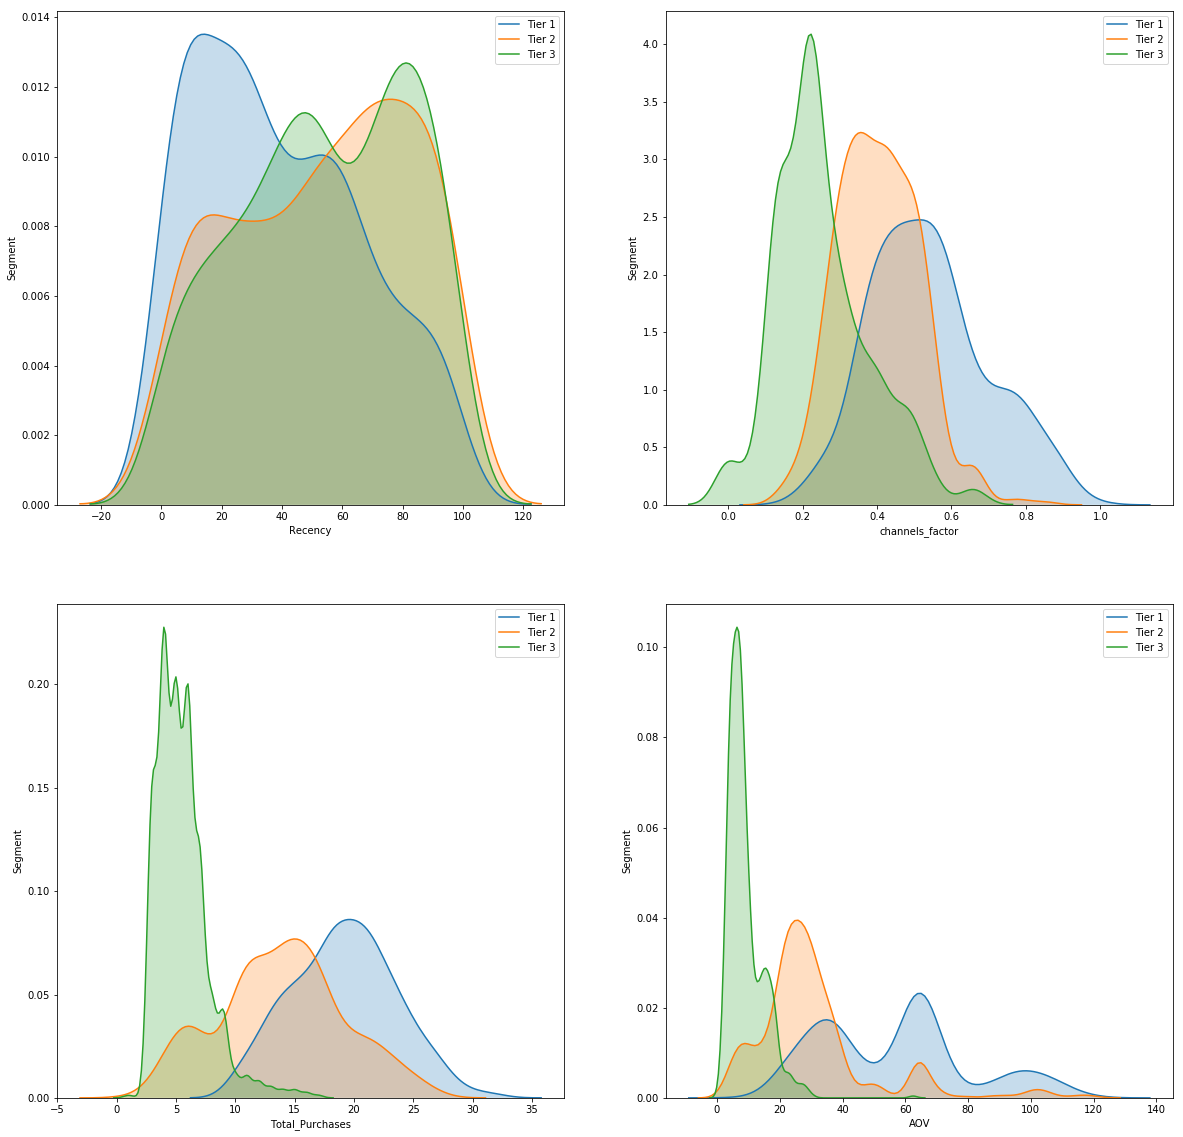

In [1078]:
import seaborn as sns
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 20)
#sns.barplot(x='Segment',y='Response',data=df,ax=axes[0][0])

sns.kdeplot(df['Recency'].loc[df.Segment == 'Tier 1'], shade=True,label='Tier 1',ax=axes[0][0])
sns.kdeplot(df['Recency'].loc[df.Segment == 'Tier 2'], shade=True, label='Tier 2',ax=axes[0][0])
sns.kdeplot(df['Recency'].loc[df.Segment == 'Tier 3'], shade=True, label='Tier 3',ax=axes[0][0])

sns.kdeplot(df['channels_factor'].loc[df.Segment == 'Tier 1'], shade=True,label='Tier 1',ax=axes[0][1])
sns.kdeplot(df['channels_factor'].loc[df.Segment == 'Tier 2'], shade=True, label='Tier 2',ax=axes[0][1])
sns.kdeplot(df['channels_factor'].loc[df.Segment == 'Tier 3'], shade=True, label='Tier 3',ax=axes[0][1])

sns.kdeplot(df['Total_Purchases'].loc[df.Segment == 'Tier 1'], shade=True,label='Tier 1',ax=axes[1][0])
sns.kdeplot(df['Total_Purchases'].loc[df.Segment == 'Tier 2'], shade=True, label='Tier 2',ax=axes[1][0])
sns.kdeplot(df['Total_Purchases'].loc[df.Segment == 'Tier 3'], shade=True, label='Tier 3',ax=axes[1][0])

sns.kdeplot(df['AOV'].loc[df.Segment == 'Tier 1'], shade=True,label='Tier 1',ax=axes[1][1])
sns.kdeplot(df['AOV'].loc[df.Segment == 'Tier 2'], shade=True, label='Tier 2',ax=axes[1][1])
sns.kdeplot(df['AOV'].loc[df.Segment == 'Tier 3'], shade=True, label='Tier 3',ax=axes[1][1])

axes[0][0].set(ylabel='Segment', xlabel='Recency')
axes[0][1].set(ylabel='Segment', xlabel='channels_factor')
axes[1][0].set(ylabel='Segment', xlabel='Total_Purchases')
axes[1][1].set(ylabel='Segment', xlabel='AOV')


<br> 

Now we have 3 Customers Segments that might be described as:
<br>
<il>
    <li><b>Tier 1 (501 customers)</b>: Group of customers with higher AOV, amount of purchases and recent purchases. They also tend to buy less through Stores</li>
    <li><b>Tier 2 (566 customers)</b>: Group with values in the middle</li>
    <li><b>Tier 3 (873 customers)</b>:Group of inactive customers, with low AOV and usualy make purchases in Stores</li>
</il>


Lets see how our clusters would perform in the Campaings:

[Text(0, 0.5, 'Response'), Text(0.5, 0, 'AcceptedCmp5')]

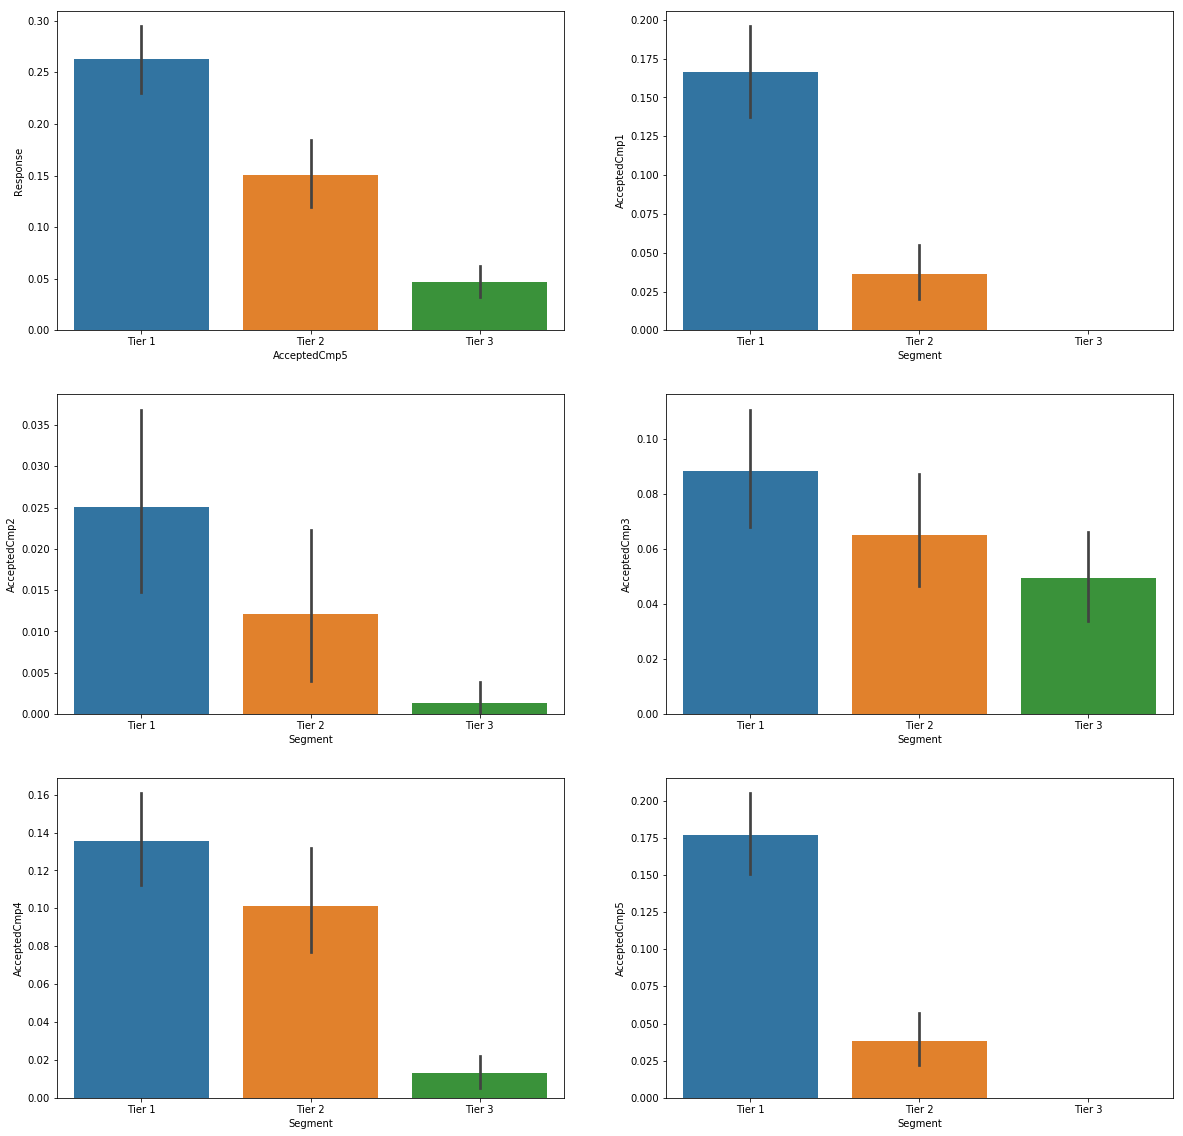

In [1079]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(20, 20)
sns.barplot(x='Segment',y='Response',data=df,ax=axes[0][0])
sns.barplot(x='Segment',y='AcceptedCmp1',data=df,ax=axes[0][1])
sns.barplot(x='Segment',y='AcceptedCmp2',data=df,ax=axes[1][0])
sns.barplot(x='Segment',y='AcceptedCmp3',data=df,ax=axes[1][1])
sns.barplot(x='Segment',y='AcceptedCmp4',data=df,ax=axes[2][0])
sns.barplot(x='Segment',y='AcceptedCmp5',data=df,ax=axes[2][1])


axes[0][0].set(xlabel='Segment', ylabel='Response')
axes[0][0].set(xlabel='AcceptedCmp1', ylabel='Response')
axes[0][0].set(xlabel='AcceptedCmp2', ylabel='Response')
axes[0][0].set(xlabel='AcceptedCmp3', ylabel='Response')
axes[0][0].set(xlabel='AcceptedCmp4', ylabel='Response')
axes[0][0].set(xlabel='AcceptedCmp5', ylabel='Response')

As we can see, our Tier 1 Customers converted more than Tier 3 customers <b>in every campaign</b>. With the <b>conversion rate ~6x more than Tier 3 Customers in the last campaing.</b>

In [1080]:
Cluster_dummies=pd.get_dummies(df['Segment'], drop_first=True)

In [1081]:
df=pd.concat([df,Cluster_dummies], axis=1)
df.drop(['Segment','Cluster_AOV','Cluster_Recency','Cluster_Channels','Cluster_Purchases'],axis=1,inplace=True)

In [1082]:
df.to_csv('data_modelo.csv')